Testing the deflection angle grid using:
    1. Only MGE parametrization
    2. MGE light star parametrization + analytical mass model
    
For the analytical mass model we are using:
1. __Spherical NFW model__.
    This choise is motivated by our previous parametrization of this profile. In this way, we can compare the results, once the same NFW model are used in both inversion.
 
 
2. __Ellipitical NFW model__.
    In this case, we want to see if the MGE parametrization of Spherical NFW can reproduce the Elliptical NFW just changing the axial ratio q_dm. For that, we assume that the major axis is coincident with the x-axis.

In [35]:
import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import z_at_value
from astropy.cosmology import Planck15 as cosmo

Grid with pixel position, in arcsec.

In [36]:
grid = al.Grid.uniform(shape_2d=(80, 80), pixel_scales=0.09, sub_size=1)

In [37]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)           #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("SphNFW_2e3arcsec.txt", unpack=True)     #DM component


In [38]:
#Input
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 1.00                                                          #kappa_s of DM halo
r_s    = 11.5                                                          #scale radius os dm halo
ml     = 7.7                                                           #mass to light ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

# Spherical Models

## Only sMGE parametrization

In [39]:
#Initializing
mass_profile_MGE = al.mp.MGE()


#Components
mass_profile_MGE.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm=kappa_*surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [40]:
%timeit mass_profile_MGE.deflections_from_grid(grid)

3.52 s ± 55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## sMGE + sNFW

In [41]:
#Initializing
mass_profile_BOTH = al.mp.MGE()

#Analytical DM
sNFW = al.mp.dark_mass_profiles.SphericalNFW(kappa_s=kappa_, scale_radius=r_s)                

#Components of MGE, only stars
mass_profile_BOTH.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml, mbh=mbh)

#Including analytic model for DM
mass_profile_BOTH.Analytic_Model(analytic_profile=sNFW)

In [42]:
%timeit mass_profile_BOTH.deflections_from_grid(grid)

2.71 s ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Ploting result

In [43]:
result_MGE  = mass_profile_MGE.deflections_from_grid(grid)
result_BOTH = mass_profile_BOTH.deflections_from_grid(grid)

Text(0, 0.5, '$|\\frac{sMGE - sNFW}{sMGE}|$ (%)')

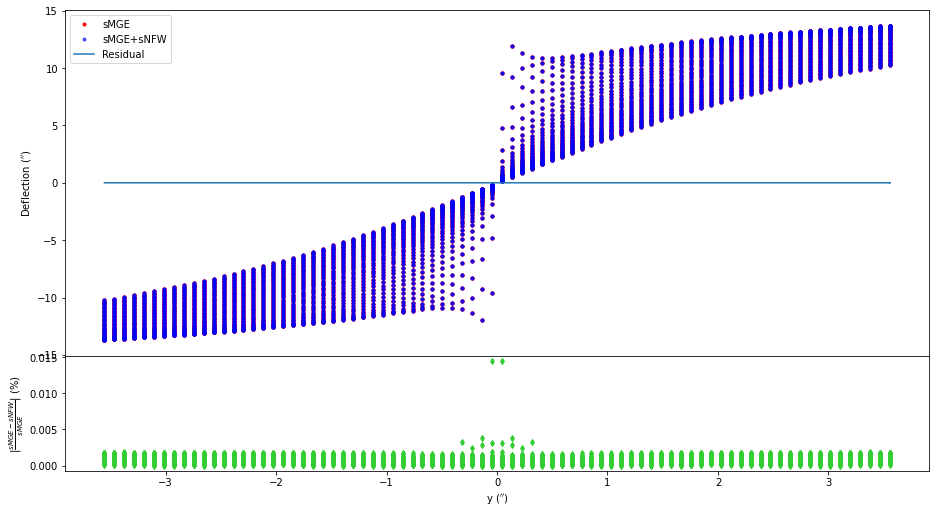

In [49]:
#PLOT
fig1 = plt.figure(figsize=(15,8))

#Plot Data-model
frame1 = fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(grid[:,0],result_MGE[:,0], ".r", label="sMGE")
plt.plot(grid[:,0],result_BOTH[:,0], ".b", label="sMGE+sNFW", alpha=0.6)
plt.plot(grid[:,0],result_MGE[:,0]-result_BOTH[:,0], label="Residual")

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel("Deflection ($''$)")
plt.legend()


#Residual plot
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot(grid[:,0],100 * np.abs((result_MGE[:,0]-result_BOTH[:,0])/result_BOTH[:,0]),'d',
                 color='LimeGreen', mec='LimeGreen', ms=4)

plt.xlabel("y ($''$)")
plt.ylabel("$|\\frac{sMGE - sNFW}{sMGE}|$ (%)")

Text(0, 0.5, '$|\\frac{sMGE - sNFW}{sMGE}|$ (%)')

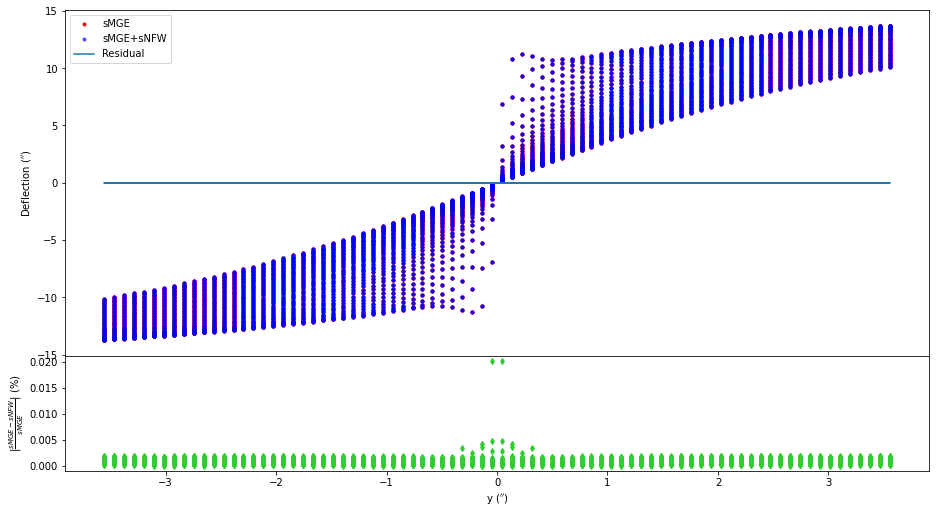

In [50]:
#PLOT
fig1 = plt.figure(figsize=(15,8))

#Plot Data-model
frame1 = fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(grid[:,1],result_MGE[:,1], ".r", label="sMGE")
plt.plot(grid[:,1],result_BOTH[:,1], ".b", label="sMGE+sNFW", alpha=0.6)
plt.plot(grid[:,1],result_MGE[:,1]-result_BOTH[:,1], label="Residual")

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel("Deflection ($''$)")
plt.legend()


#Residual plot
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot(grid[:,1],100 * np.abs((result_MGE[:,1]-result_BOTH[:,1])/result_BOTH[:,1]),'d',
                 color='LimeGreen', mec='LimeGreen', ms=4)

plt.xlabel("y ($''$)")
plt.ylabel("$|\\frac{sMGE - sNFW}{sMGE}|$ (%)")

# Ellipitical Models

## Only eMGE parametrization

In [67]:
#Initializing
q_dm   = 0.75                   #Projected axial ratio of DM
phi_dm = 0.00                   #Orientation of DM, counterclockwise from x-axis

mass_profile_MGE = al.mp.MGE()
qobs_dm = np.full_like(qobs_dm, q_dm)  #changing the axial ratio of DM for eMGE

#Components
mass_profile_MGE.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm=kappa_*surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [68]:
%timeit mass_profile_MGE.deflections_from_grid(grid)

3.75 s ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# eMGE + eNFW

In [69]:
#Initializing
mass_profile_BOTH = al.mp.MGE()
ell_comps = al.convert.elliptical_comps_from(axis_ratio=q_dm, phi=phi_dm) #Elliptical components in Pyautolens units

#Analytical DM
eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s)                

#Components of MGE, only stars
mass_profile_BOTH.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml, mbh=mbh)

#Including analytic model for DM
mass_profile_BOTH.Analytic_Model(analytic_profile=eNFW)

In [70]:
%timeit  mass_profile_BOTH.deflections_from_grid(grid)

2.76 s ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Ploting result

In [71]:
result_MGE  = mass_profile_MGE.deflections_from_grid(grid)
result_BOTH = mass_profile_BOTH.deflections_from_grid(grid)

Text(0, 0.5, '$|\\frac{eMGE - eNFW}{eMGE}|$ (%)')

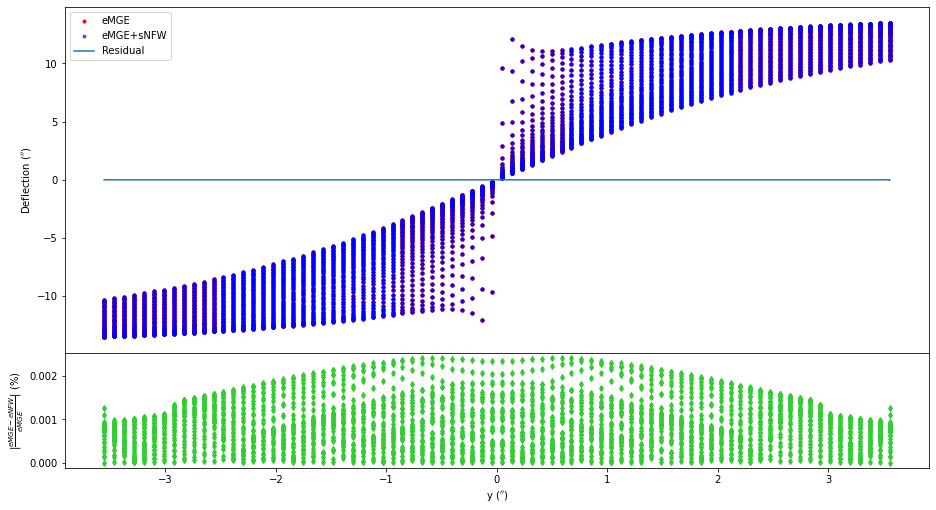

In [72]:
#PLOT
fig1 = plt.figure(figsize=(15,8))

#Plot Data-model
frame1 = fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(grid[:,0],result_MGE[:,0], ".r", label="eMGE")
plt.plot(grid[:,0],result_BOTH[:,0], ".b", label="eMGE+sNFW", alpha=0.6)
plt.plot(grid[:,0],result_MGE[:,0]-result_BOTH[:,0], label="Residual")

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel("Deflection ($''$)")
plt.legend()


#Residual plot
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot(grid[:,0],100 * np.abs((result_MGE[:,0]-result_BOTH[:,0])/result_BOTH[:,0]),'d',
                 color='LimeGreen', mec='LimeGreen', ms=4)

plt.xlabel("y ($''$)")
plt.ylabel("$|\\frac{eMGE - eNFW}{eMGE}|$ (%)")

Text(0, 0.5, '$|\\frac{eMGE - eNFW}{eMGE}|$ (%)')

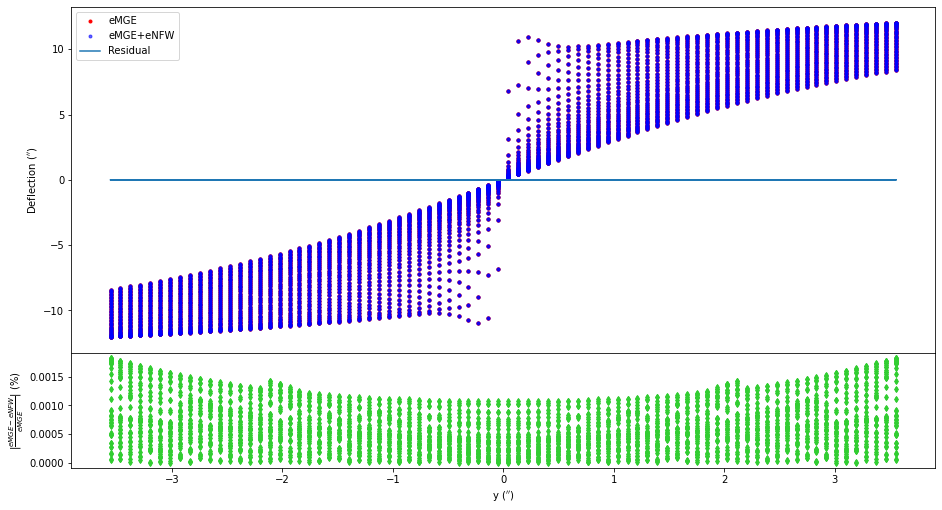

In [73]:
#PLOT
fig1 = plt.figure(figsize=(15,8))

#Plot Data-model
frame1 = fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(grid[:,1],result_MGE[:,1], ".r", label="eMGE")
plt.plot(grid[:,1],result_BOTH[:,1], ".b", label="eMGE+eNFW", alpha=0.6)
plt.plot(grid[:,1],result_MGE[:,1]-result_BOTH[:,1], label="Residual")

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel("Deflection ($''$)")
plt.legend()


#Residual plot
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot(grid[:,1],100 * np.abs((result_MGE[:,1]-result_BOTH[:,1])/result_BOTH[:,1]),'d',
                 color='LimeGreen', mec='LimeGreen', ms=4)

plt.xlabel("y ($''$)")
plt.ylabel("$|\\frac{eMGE - eNFW}{eMGE}|$ (%)")